![alt text](img/MIoT_ML.png "MIoT_ML")
# Unidad 04  Entrenamiento de Modelos de Aprendizaje Automático

El objetivo principal de esta práctica es el conocer los pasos básicos para el desarrollo, optimización y evaluación de los modelos de Aprendizaje Automático. 
El Notebook contiene varios ejercicios sencillos. Debéis desarrollarlos durante la clase y subirlos al aula virtual.

## Referencias útiles para la práctica
1. API Pandas: [https://pandas.pydata.org/docs/reference/index.html](https://pandas.pydata.org/docs/reference/index.html)
2. API Scikit-learn: [https://scikit-learn.org/stable/api/index.html](https://scikit-learn.org/stable/api/index.html)
3. Dataset para el ejercicio: [https://www.kaggle.com/datasets/camnugent/california-housing-prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)
4. Géron, Aurélien. Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.", 2022.
5. Bergstra, J., & Bengio, Y. (2012). Random search for hyperparameter optimization. Journal of machine learning research, 13 (2). *Para profundizar en la optimización de hiperparámetros*
6. Girish Chandrashekar and Ferat Sahin. A survey on feature selection methods. Computers & Electrical Engineering, 40(1):16–28, 2014
   
## 1. Flujo de trabajo básico en problemas de Aprendizaje Automático (*ML workflow*)
A la hora de enfrentarnos a un nuevo problema de Aprendizaje Automático (ML), existen una serie de pasos típicos y comunes que debemos afrontar:
1. Entender el problema y su contexto.
2. Obtener los datos (histórico).
3. Explorar, analizar y entender los datos.
4. Preparar los datos para los modelos.
5. Seleccionar, optimizar y entrenar los modelos ML.
6. Evaluar y presentar el modelo seleccionado.
7. Desplegar, monitorizar y mantener la solución.

En esta unidad nos centraremos en los pasos 5 y 6 del flujo de trabajo.

## 2. Carga y partición de datos
### 2.1. Carga de los datos
Cargaremos los datos generados durante la Unidad02, almacenados al finalizar la misma. Suponemos que se han mantenido los nombres generados durante dicha unidad, y que los datos están almacenados en el directorio raíz.

- Características de entrada preprocesadas (*Inputs*) de las observaciones del conjunto de entrenamiento (*preprocessing_trainset_inputs.csv*).
- Etiquetas de salida (*Outputs*) de las observaciones del conjunto de entrenamiento (*trainset_ouputs.csv*).
- Características de entrada preprocesadas (*Inputs*) de las observaciones del conjunto de Test (*preprocessing_testset_inputs.csv*).
- Etiquetas de salida (*Outputs*) de las observaciones del conjunto de Test (*testset_outputs.csv*).
- Columna de los índices "*idx*" (tal como se guardó en la Unidad 02).

In [1]:
# pandas library
import pandas as pd
try:
    import pandas as pd
except ImportError as err:
    !pip install pandas
    import pandas as pd

# leemos los datos de training, indicando que la columna que tiene los índices originales es "idx", que se mantendrá en los nuevos Dataframes
training_inputs = pd.read_csv("./preprocessing_trainset_inputs.csv", index_col="idx")
training_outputs = pd.read_csv("./trainset_ouputs.csv", index_col="idx")
print("Longitud del conjunto de entrenamiento:", len(training_inputs))

# leemos los datos de testing
testing_inputs = pd.read_csv("./preprocessing_testset_inputs.csv", index_col="idx")
testing_outputs = pd.read_csv("./testset_outputs.csv", index_col="idx")
print("Longitud del conjunto de test:", len(testing_inputs))

Longitud del conjunto de entrenamiento: 13758
Longitud del conjunto de test: 5916


### 2.2. Creación del conjunto de validación

Vamos a dividir el conjunto de test original en dos conjuntos de igual tamaño: el conjunto de validación, que emplearemos para seleccionar los hiperparámetros que den mejores resultados; y el conjunto de test propiamente dicho, que emplearemos para medir la calidad del modelo.

In [2]:
try:
    from sklearn.model_selection import train_test_split
except ImportError as err:
    !pip install sklearn
    from sklearn.model_selection import train_test_split

SEED=1234

# dividimos el conjunto de test original: testing_inputs
test_inputs, val_inputs = train_test_split(testing_inputs, test_size=0.5, train_size=0.5, random_state=SEED, shuffle=True)

# generamos los outputs correspondientes a los dos conjuntos creados
# val_inputs.index es la lista de índices seleccionados para el conjunto de inputs de validación
# deben ser los mismos índices para el conjunto de outputs de validación
val_outputs = testing_outputs.loc[val_inputs.index]
print("Longitud del conjunto de validación:", len(val_outputs))

# igualmente para el conjunto de test
test_outputs = testing_outputs.loc[test_inputs.index]
print("Longitud del conjunto de test:", len(test_outputs))

Longitud del conjunto de validación: 2958
Longitud del conjunto de test: 2958


## 3. Creación y evaluación de un modelo básico

### 3.1. Selección de una métrica de evaluación

Para medir la calidad del modelo que vamos a desarrollar, necesitamos seleccionar una métrica que nos dé un valor que cuantifique la diferencia entre los datos conocidos del conjunto de test y los datos predichos por el modelo. 
Una medida de rendimiento típica para los problemas de regresión es el error cuadrático medio (RMSE) que nos da una idea de cuánto error suele cometer el sistema en sus predicciones en las mismas unidades que la variable dependiente, lo que puede facilitar la interpretación de los resultados. 

$$RMSE=\large\sqrt{\frac{1}{n} \sum_{i=1}^N{ (\hat{y}_i-y_i)^2}}$$



El RMSE tiene una serie de características que debemos tener en cuenta a la hora de seleccionarlo como, por ejemplo: 

* Promedia los errores individuales sin tener en cuenta el signo.
    * No informa de los sesgos sistemáticos (ej. el modelo tiende a sobrestimar o subestimar).
* Penaliza los errores grandes.
* Muy sensible a los atípicos (*outliers*).
    * Pueden disparar la métricas y dar una percepción inexacta.
 
Existen otras métricas interesantes para regresión que debemos valorar dependiendo de nuestro objetivo y nuestro problema. Por ejemplo, si el número de *outliers* en nuestras manzanas fuese muy alto, quizás nos conveniese emplear una métrica robusta contra los atípicos como el error absoluto medio (MAE):

$$\large MAE=\frac{1}{N}\sum_{i=1}^N|y_i-\hat{y}_i|$$



En nuestro caso, vamos a emplear la métrica RMSE (en Scikit-learn está disponible mediante la función "[*root_mean_squared_error*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html)").

In [3]:
from sklearn.metrics import root_mean_squared_error


### 3.2. Creación y evaluación de un modelo básico
#### 3.2.1. Creación de un modelo de regresión lineal

Como dijimos en la unidad anterior, en la vida real normalmente no programaremos un modelo, sino que eligiremos uno de los muchos que hay en las librerías conocidas, como Scikit-learn. En este caso, vamos a elegir un modelo básico de regresión lineal multivariable (varios atributos de entrada), que en Scitkit-learn es implementado por la clase **LinearRegression**. Y llamaremos a su función *fit* pasándole las entradas y los valores reales (del conjunto de entrenamiento) para que entrene el modelo con esos datos y ajuste los parámetros del modelo.

**Nota**: se puede añadir al propio pipeline de preprocesado

In [4]:
from sklearn.linear_model import LinearRegression

model_lin_reg = LinearRegression()
model_lin_reg.fit(training_inputs, training_outputs)


LinearRegression()

#### 3.2.2. Evaluación con el dataset de entrenamiento

Una vez entrenado el modelo con el conjunto de entrenamiento, podemos ver qué tal es su desempeño sobre el conjunto de entrenamiento (midiéndolo con la métrica RMSE). El grado de acierto sobre las primeras muestras:


In [5]:

training_predictions = model_lin_reg.predict(training_inputs)

print("Primeras 5 observaciones del entrenamiento")
for real, pred in zip(training_predictions[:5].round(-2) ,training_outputs.iloc[:5].values):
    print(f"Valor real: {real}, valor predicho: {pred}. Diferencia en absoluto{abs(real-pred)}. Porcentaje desvío: {(abs(real-pred)*100/real).round(2)}%")


Primeras 5 observaciones del entrenamiento
Valor real: [280200.], valor predicho: [335400.]. Diferencia en absoluto[55200.]. Porcentaje desvío: [19.7]%
Valor real: [287700.], valor predicho: [470000.]. Diferencia en absoluto[182300.]. Porcentaje desvío: [63.36]%
Valor real: [207700.], valor predicho: [170800.]. Diferencia en absoluto[36900.]. Porcentaje desvío: [17.77]%
Valor real: [140400.], valor predicho: [225000.]. Diferencia en absoluto[84600.]. Porcentaje desvío: [60.26]%
Valor real: [198500.], valor predicho: [155300.]. Diferencia en absoluto[43200.]. Porcentaje desvío: [21.76]%


Y el grado de acierto sobre todo el dataset de entrenamiento.

In [6]:

rmse_train = root_mean_squared_error(training_outputs, training_predictions)
print(f"RMSE del conjunto de entrenamiento con modelo de regresión lineal: {rmse_train.round(2)}")

RMSE del conjunto de entrenamiento con modelo de regresión lineal: 64102.07


#### 3.2.3. Evaluación con un conjunto de datos no visto previamente

Veamos ahora cómo se comporta el modelo con un conjunto de datos que no ha visto durante el entrenamiento, por ejemplo, el conjunto de validación.

In [7]:
# Evaluación con el dataset de validación para el modelo de regresión lineal
val_predictions = model_lin_reg.predict(val_inputs)
rmse_val_lr = root_mean_squared_error(val_outputs, val_predictions)
print(f"RMSE del conjunto de validación con modelo de regresión lineal: {rmse_val_lr.round(2)}")


RMSE del conjunto de validación con modelo de regresión lineal: 63616.94


### 3.3. Creación y evaluación de otro modelo (DecisionTree)

Veamos ahora otro modelo de predicción, un árbol de decisión (*decision tree*).

#### 3.3.1. Creación del modelo de árbol de decisión

Para esta tarea, tenemos la clase **DecisionTreeRegressor** del Scikit-learn.

In [8]:
from sklearn.tree import DecisionTreeRegressor
model_tree = DecisionTreeRegressor(random_state=SEED)
model_tree.fit(training_inputs, training_outputs)


DecisionTreeRegressor(random_state=1234)

#### 3.3.2. Evaluación con el dataset de entrenamiento

Una vez entrenado el modelo con el conjunto de entrenamiento, podemos ver qué tal es su desempeño sobre el conjunto de entrenamiento (midiéndolo con la métrica RMSE). El grado de acierto sobre las primeras muestras y sobre todo el conjunto de entrenamiento es:


In [9]:
training_predictions = model_tree.predict(training_inputs)

print("Primeras 5 observaciones del entrenamiento")
for real, pred in zip(training_predictions[:5].round(-2),training_outputs.iloc[:5].values):
    print(f"Valor real: {real}, valor predicho: {pred}. Diferencia en absoluto{abs(real-pred)}. Porcentaje desvío: {(abs(real-pred)*100/real).round(2)}%")

rmse_train = root_mean_squared_error(training_outputs, training_predictions)
print(f"RMSE del conjunto de entrenamiento con modelo de árbol de decisión: {rmse_train.round(2)}")



Primeras 5 observaciones del entrenamiento
Valor real: 335400.0, valor predicho: [335400.]. Diferencia en absoluto[0.]. Porcentaje desvío: [0.]%
Valor real: 470000.0, valor predicho: [470000.]. Diferencia en absoluto[0.]. Porcentaje desvío: [0.]%
Valor real: 170800.0, valor predicho: [170800.]. Diferencia en absoluto[0.]. Porcentaje desvío: [0.]%
Valor real: 225000.0, valor predicho: [225000.]. Diferencia en absoluto[0.]. Porcentaje desvío: [0.]%
Valor real: 155300.0, valor predicho: [155300.]. Diferencia en absoluto[0.]. Porcentaje desvío: [0.]%
RMSE del conjunto de entrenamiento con modelo de árbol de decisión: 0.0


**¿Qué ha pasado? ¿Cómo puede ser que no tenga ningún error?**

**EJERCICIO**
Explica en una celda de texto qué puede estar pasando para que no exista error



In [10]:
# EJERCICIO
# Explica en esta celda de texto que puede estar pasando para que no exista error





#### 3.3.3. Evaluación con un conjunto de datos no visto previamente

Veamos ahora cómo se comporta el modelo con un conjunto de datos que no ha visto durante el entrenamiento, por ejemplo, el conjunto de validación.

In [11]:

val_predictions = model_tree.predict(val_inputs)
rmse_val_dt = root_mean_squared_error(val_outputs, val_predictions)
print(f"RMSE del conjunto de validación con el modelo árbol de decisión: {rmse_val_dt.round(2)}")

RMSE del conjunto de validación con el modelo árbol de decisión: 76521.31


### 3.4. Creación y evaluación de otro modelo (*Random Forest*)

Veamos ahora otro modelo de predicción, uno llamado *Random Forest*, que es un *ensemble* (conjunto) de *decision trees*. Cada uno se entrena con un conjunto aleatorio de los datos y de los atributos. Al final, se promedia el resultado entre todos los árboles.

Para esta tarea, tenemos la clase **RandomForestRegressor** del Scikit-learn.

In [12]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
    
model_forest = RandomForestRegressor(n_estimators=80, random_state=SEED)
# ravel() convierte el segundo parámetro en un array 1D, lo que necesita su fit, DecisionTreeRegressor acepta ambos (1D o 2D)
model_forest.fit(training_inputs, np.array(training_outputs).ravel()) 
training_predictions = model_forest.predict(training_inputs)

print("Primeras 5 observaciones del entrenamiento")
for real, pred in zip(training_predictions[:5].round(-2),training_outputs.iloc[:5].values):
    print(f"Valor real: {real}, valor predicho: {pred}. Diferencia en absoluto{abs(real-pred)}. Porcentaje desvío: {(abs(real-pred)*100/real).round(2)}%")

rmse_train = root_mean_squared_error(training_outputs, training_predictions)
print(f"RMSE del conjunto de entrenamiento con modelo de random forest: {rmse_train.round(2)}")

val_predictions = model_forest.predict(val_inputs)
rmse_val_rf = root_mean_squared_error(val_outputs, val_predictions)
print(f"RMSE del conjunto de validación con el modelo random forest: {rmse_val_rf.round(2)}")


Primeras 5 observaciones del entrenamiento
Valor real: 328900.0, valor predicho: [335400.]. Diferencia en absoluto[6500.]. Porcentaje desvío: [1.98]%
Valor real: 414100.0, valor predicho: [470000.]. Diferencia en absoluto[55900.]. Porcentaje desvío: [13.5]%
Valor real: 171900.0, valor predicho: [170800.]. Diferencia en absoluto[1100.]. Porcentaje desvío: [0.64]%
Valor real: 187200.0, valor predicho: [225000.]. Diferencia en absoluto[37800.]. Porcentaje desvío: [20.19]%
Valor real: 166500.0, valor predicho: [155300.]. Diferencia en absoluto[11200.]. Porcentaje desvío: [6.73]%
RMSE del conjunto de entrenamiento con modelo de random forest: 20792.01
RMSE del conjunto de validación con el modelo random forest: 54990.71


**Conclusión:** Como vemos, el modelo *Random Forest* da mejores resultados sobre el conjunto de validación.

In [13]:
print("RSME LR =", rmse_val_lr, "    RSME DT =", rmse_val_dt, "    RSME RF =", rmse_val_rf)

RSME LR = 63616.93786689841     RSME DT = 76521.31321932255     RSME RF = 54990.70960432677


## 4. Selección de características

Trabajar con muchos atributos (dimensiones) puede parecer lo adecuado cuando tenemos que generar modelos y buscamos un alto rendimiento, pero la realidad es que cuando aumenta la dimensionalidad, el volumen del espacio de características aumenta exponencialmente haciendo que los datos disponibles estén muy dispersos, lo que dificultará el trabajo de los modelos y que estos converjan y, como resultado, su rendimiento no será bueno. Es la llamada maldición de la dimensionalidad. El volumen y variabilidad de datos que necesitamos para entrenar en entornos de alta dimensionalidad es muy alto. Habitualmente, los modelos se ven beneficiados si reducimos la dimensionalidad. Una posibilidad para reducirla es aplicar técnicas de selección de las características (Feature Selection, FS), es decir, eliminar las características que proporcionen poca o ninguna información al modelo. La aplicación de estas técnicas tiene como consecuencia directa reducir las dimensiones e indirectamente nos proporciona información sobre el problema con el que estamos trabajando (nos muestra las variables más relevantes). Las técnicas de selección de características se engloban en 3 grandes grupos:

**Nota**: *encontrareis una explicación más detallada de este apartado en la teoría de la materia*.

### 4.1. Filtros:  
Técnicas de preprocesado que crean listas ordenadas de las características en base a algún tipo de métrica. El objetivo es eliminar las características con peores posiciones en el ranking (es necesario establecer un umbral).
* Son métodos simples y rápidos.
* Son robustos al sobreentrenamiento.
* Son fácilmente interpretables.
* Asignar el umbral no es sencillo.
* No valoran la combinación de variables (dos variables independientes no aportan información al modelo, pero combinadas sí).
* Variables altamente correladas y redundantes no se eliminan (si dos variables tienen una muy alta correlación entre ellas, es decir, representan lo mismo, es probable que no tenga sentido mantener las dos).


Scikit-Learn proporcina varios métodos de filtrado para poder aplicar sobre nuestros datos. 2 posibles estrategias una vez aplicado el método es:
1. Seleccionar las 'k' características mejor posicionadas en el ranking.
2. Seleccionar un porcetanje de las mejores características según el orden del rankin

Las 10 características con mayor correlación:
 rooms_per_house__ratio
 log__total_bedrooms
 log__total_rooms
 log__households
 log__median_income
 cat__ocean_proximity_<1H OCEAN
 cat__ocean_proximity_NEAR BAY
 cat__ocean_proximity_NEAR OCEAN
 disc__housing_median_age_0.0_0.0
 disc__housing_median_age_3.0_1.0


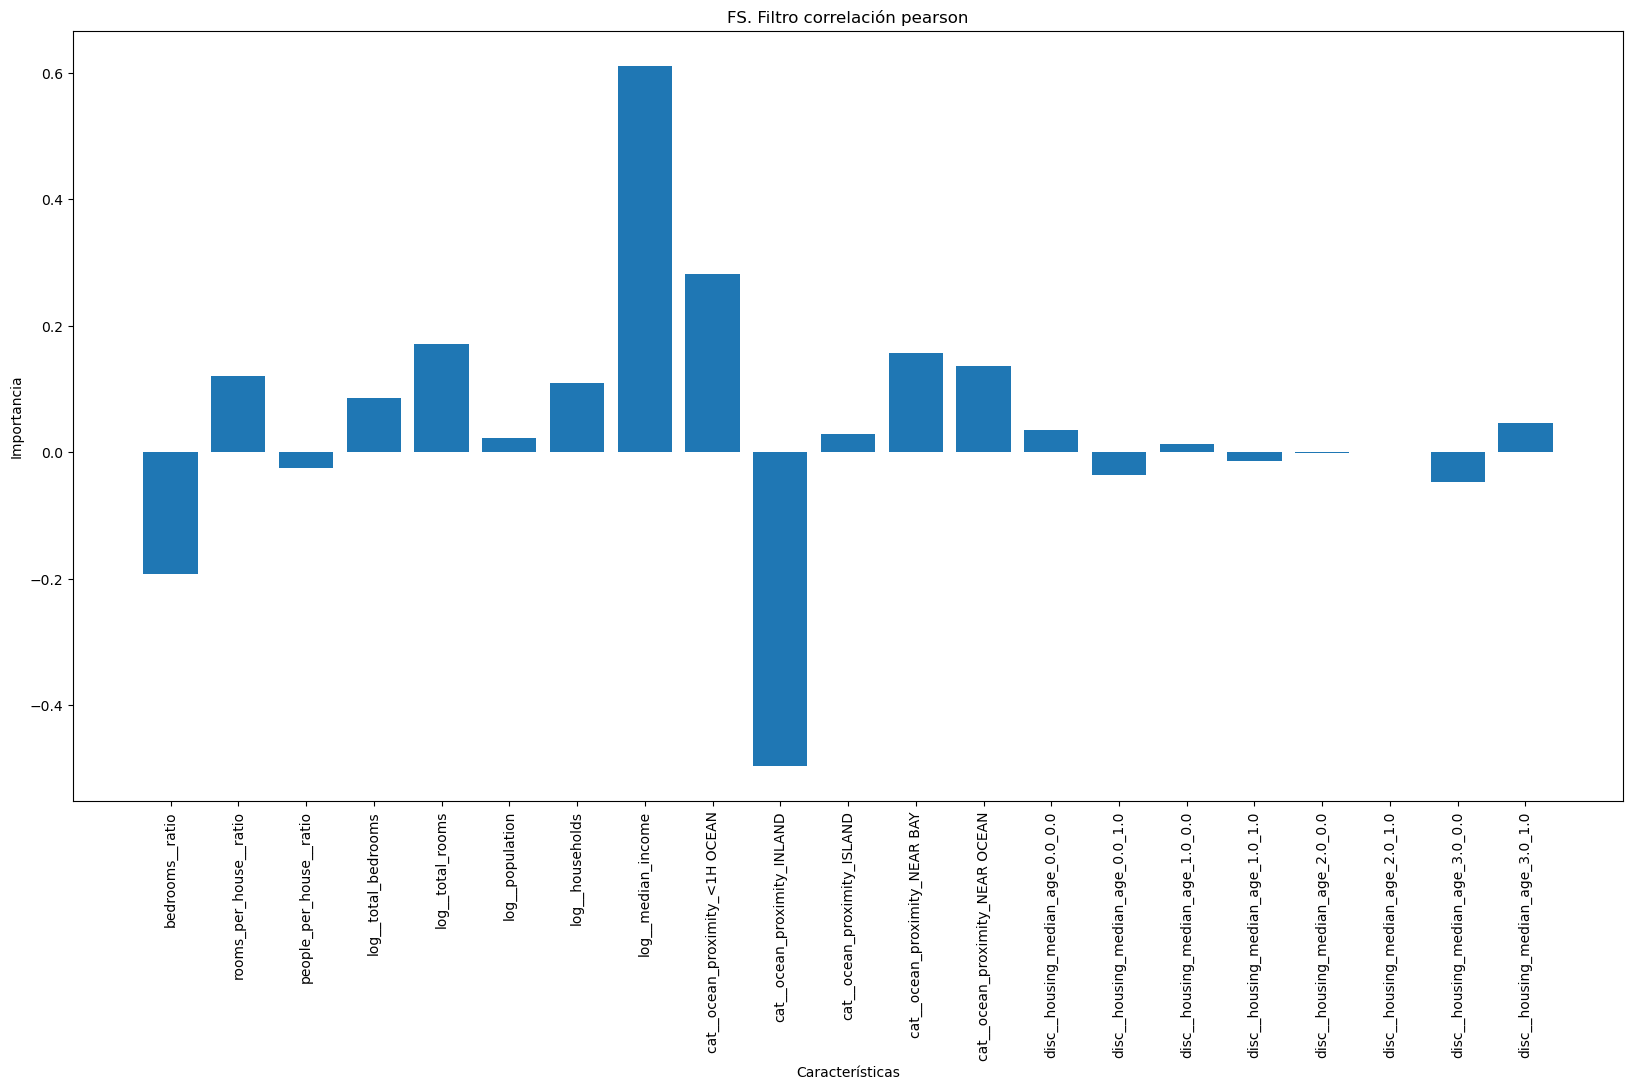

In [27]:
## Ejemplos con filtros empleando scikit-learn
from sklearn.feature_selection import SelectKBest, r_regression
try:
    import matplotlib.pyplot as plt
except ImportError as err:
    !pip install matplotlib
    import matplotlib.pyplot as plt

def plot_selected_features(features, scores, title=None, err=None):
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    plt.xlabel("Características")
    plt.ylabel("Importancia")
    plt.title(title)
    plt.bar(features,scores,orientation='vertical', yerr=err )
    plt.show()


#Seleccionamos las 'K' mejores características
K=10
#calculamos la correlación entre las variables de entrada y la salida y seleccionamos las de mayor correlación de pearson
f_selector = SelectKBest(r_regression, k=K)

# Necesitamos convertir el dataframe "training_outputs" en un array de 1D. training_outputs.values.ravel()
#training_outputs.values devuelve los valores en forma de array multidimensional
#raining_outputs.values.ravel() "aplana" el array
f_selector.fit(training_inputs, training_outputs.values.ravel())

#las K características con mayor correlación
print(f"Las {K} características con mayor correlación:\n "+"\n ".join(f_selector.get_feature_names_out(training_inputs.columns)))
plot_selected_features(training_inputs.columns.values, f_selector.scores_, title="FS. Filtro correlación pearson")







**Fijaos** que en el ejemplo anterior quizás no estemos seleccionando las que nos interesan porque solo estamos **seleccionando las de mayor correlación positiva**. La correlación de Pearson también nos da información interesante con la correlación negativa. Podemos modificar el código anterior para que tenga en cuenta el valor absoluto. Comprobareis en el resultado que nos selecciona otras distintas.

Las 10 características con mayor correlación:
 bedrooms__ratio
 rooms_per_house__ratio
 log__total_bedrooms
 log__total_rooms
 log__households
 log__median_income
 cat__ocean_proximity_<1H OCEAN
 cat__ocean_proximity_INLAND
 cat__ocean_proximity_NEAR BAY
 cat__ocean_proximity_NEAR OCEAN


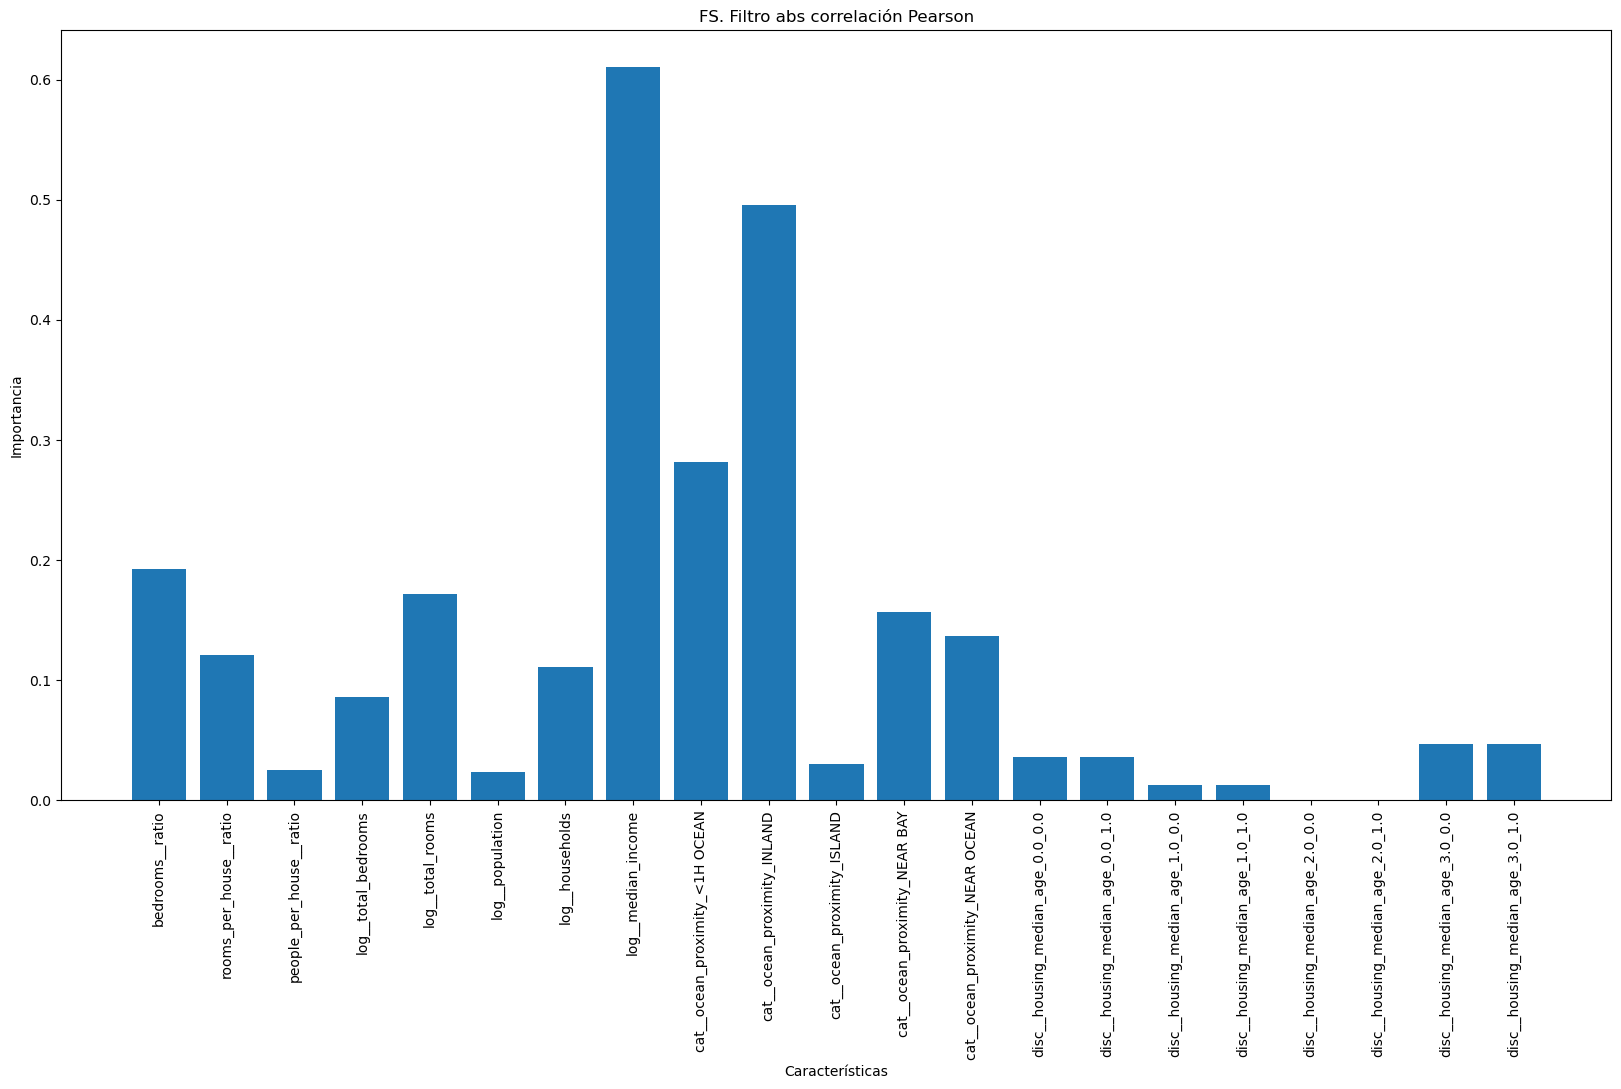

In [28]:
def abs_r_regression(inputs, outputs):
    return np.abs(r_regression(inputs, outputs))  



#Seleccionamos las 'K' mejores características
K=10
#calculamos la correlación entre las variables de entrada y la salida y seleccionamos las de mayor correlación de pearson
f_selector = SelectKBest(abs_r_regression, k=K)

# Necesitamos convertir el dataframe "training_outputs" en un array de 1D. training_outputs.values.ravel()
#training_outputs.values devuelve los valores en forma de array multidimensional
#raining_outputs.values.ravel() "aplana" el array
f_selector.fit(training_inputs, training_outputs.values.ravel())


#las K características con mayor correlación
print(f"Las {K} características con mayor correlación:\n "+"\n ".join(f_selector.get_feature_names_out(training_inputs.columns)))
plot_selected_features(training_inputs.columns.values, f_selector.scores_, title="FS. Filtro abs correlación Pearson")



### 4.2. Embebidos
Métodos que incorporan la selección de características en el proceso de entrenamiento de un modelo de ML. Dos tipos principales:
1. Aproximaciones basadas en regularización (ej. Lasso-L1). Son algoritmos que tratan de minimizar una función de coste en la que participan términos de regularización. En el proceso de construcción del modelo se eliminan las características cuyo peso sea 0 ($\beta_j = 0$).

$$\large F_{coste}=\sum_{i=1}^N(y_i-\sum(x_{ij}\beta_j))^2 + \lambda\sum_{j=1}^P|\beta_j|$$
$$\large L_1=\lambda\sum_{j=1}^P|\beta_j|$$ 
       
2. Aproximaciones basadas en la información extraída con la construcción del modelo. El ejemplo más claro son los modelos
basados en árboles en los que la propia construcción del modelo produce la selección

/home/david/miniconda3/envs/miot_ml/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.672e+12, tolerance: 1.314e+10
  model = cd_fast.enet_coordinate_descent(


Características con peso=0: 
disc__housing_median_age_1.0_1.0


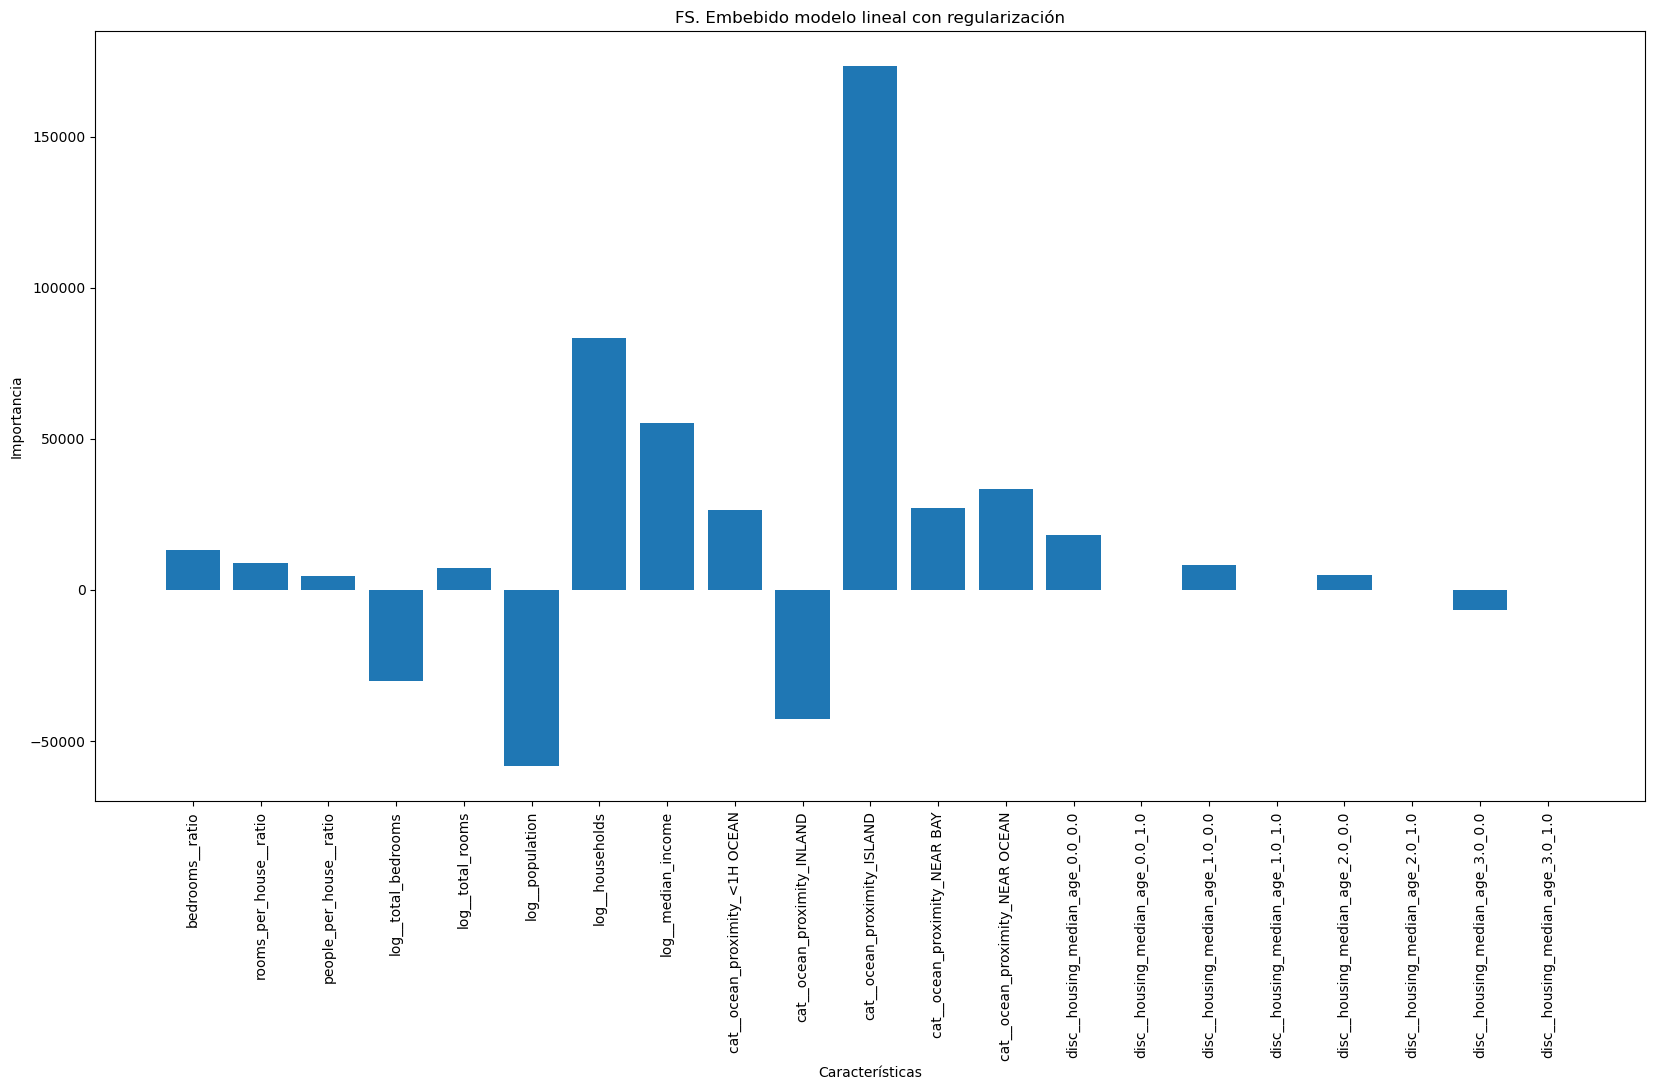

In [29]:
##Ejemplos embebidos

from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model

#Modelo de regularización
model = linear_model.Lasso(alpha=0.1, max_iter=1000)
model.fit(training_inputs,training_outputs)
#selector = SelectFromModel(estimator=model)
#selector.fit(training_inputs,training_outputs)

características_sin_relevancia=[ var for var, coef in zip(training_inputs.columns.values, model.coef_) if coef==0]

print("Características con peso=0: \n"+"\n ".join(características_sin_relevancia))    




plot_selected_features(training_inputs.columns.values, model.coef_, title="FS. Embebido modelo lineal con regularización")


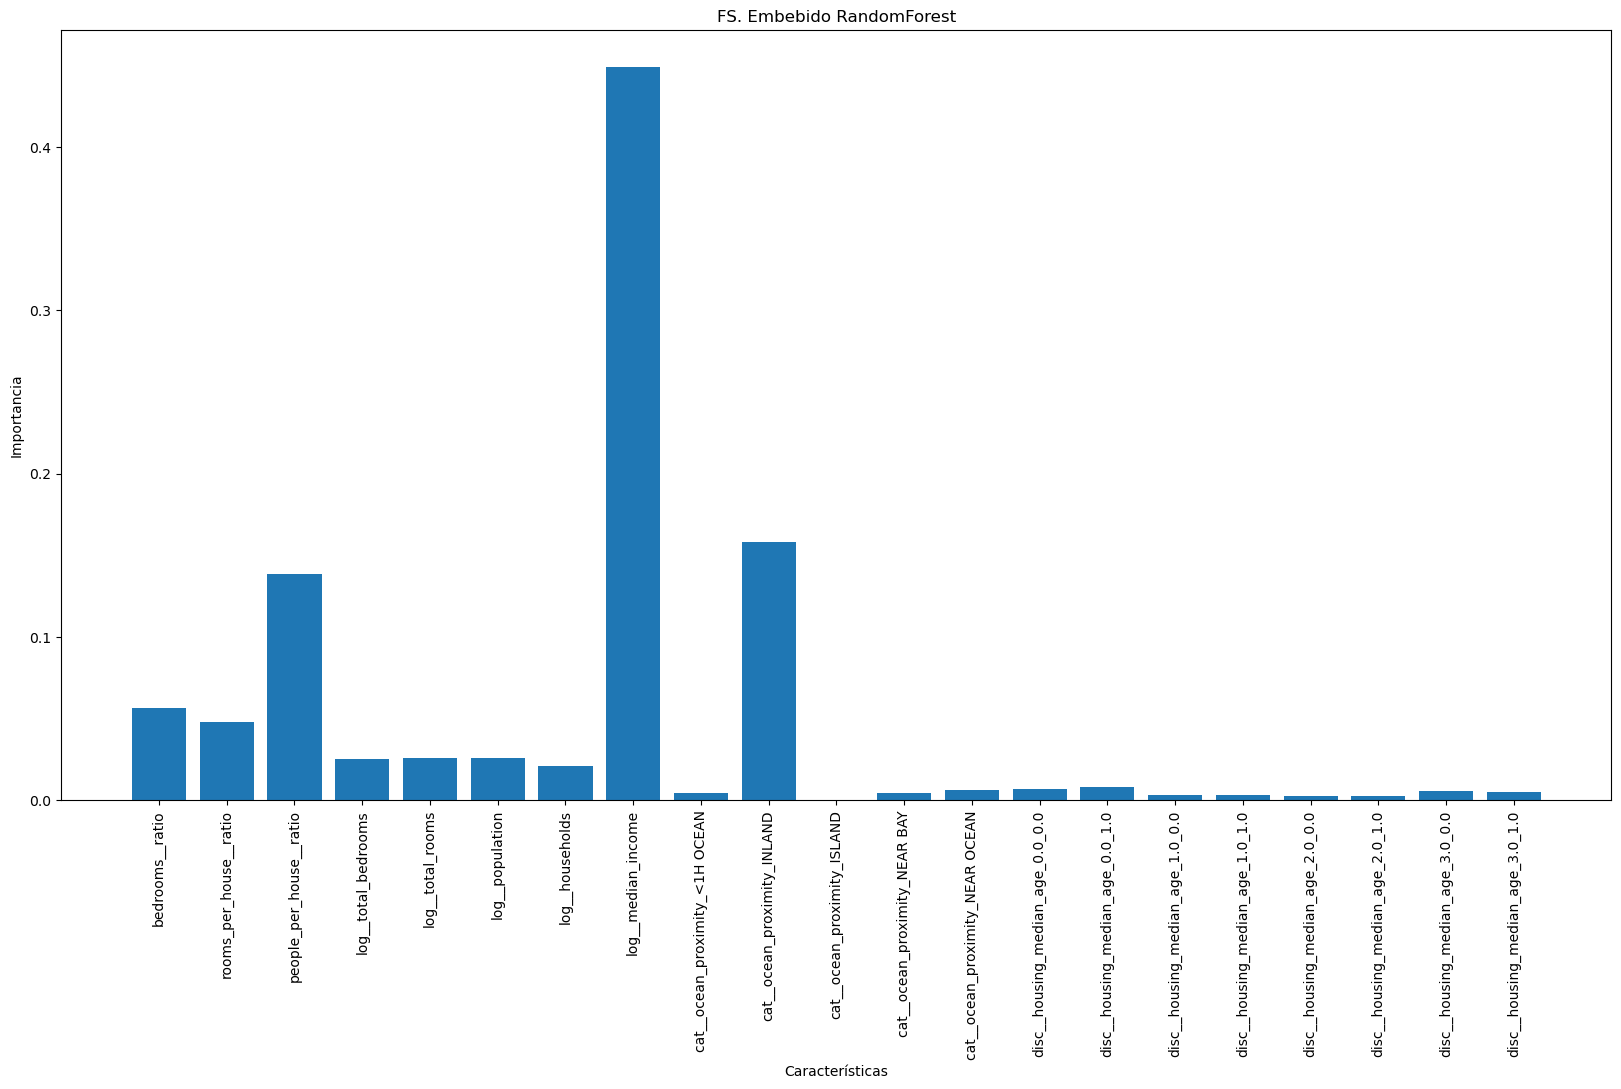

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel


model = RandomForestRegressor(n_estimators=50)
model.fit(training_inputs,training_outputs.values.ravel())

importances = model.feature_importances_ #importancia general de los atributos en el RandomForest
std = np.std([importances for tree in model.estimators_],axis=0)#Podemos calcular la importancia para cada árbol y con ello la std
plot_selected_features(training_inputs.columns.values, importances, title="FS. Embebido RandomForest")





### 4.3. Wrappers
Algoritmos que integran un predictor durante el proceso de selección. Se prueban diferentes combinaciones de atributos para entrenar un modelo y el subconjunto con mejores resultados es el seleccionado. Es inviable computacionalmente probar todas las posibles combinaciones, por lo que es necesario establecer un método de búsqueda en el espacio de características que genere los subconjuntos.
* Son simples, universales, tienen buen rendimiento (el modelo resultante) PERO:
    * Son computacionalmente muy costosos.
    * Dependen en gran medida del modelo seleccionado.
    * Pueden caer en el sobreentrenamiento.
    * Es difícil de configurar los modelos de forma justa (agregar el proceso de optimización de hiperparámetros produciría una sobrecarga muy importante).
    * Cada método para seleccionar subconjuntos tiene problemáticas asociadas que es necesario valorar.

Dos de los métodos más sencillos para establecer los conjuntos son:
1. **Sequential forward selection algorithm**:
    1. Empezamos con un conjunto vacío FS_DATASET.
    2. Añadimos a FS_DATASET la característica X que maximiza el rendimiento del modelo.
    3. Repetimos el paso 'B' hasta que se cumple la condición de salida. 


In [34]:
## Ejemplos wrappers

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import tree

#Features to select
K=10
model = tree.DecisionTreeRegressor()

sfs = SequentialFeatureSelector(model, n_features_to_select=K,direction='forward')

sfs.fit(training_inputs, training_outputs)
selected_features=sfs.get_feature_names_out(training_inputs.columns)
print("Características seleccionadas empleando SFS:\n"+"\n".join(selected_features))




Características seleccionadas empleando SFS:
cat__ocean_proximity_<1H OCEAN
cat__ocean_proximity_INLAND
cat__ocean_proximity_ISLAND
cat__ocean_proximity_NEAR BAY
cat__ocean_proximity_NEAR OCEAN
disc__housing_median_age_0.0_0.0
disc__housing_median_age_0.0_1.0
disc__housing_median_age_1.0_0.0
disc__housing_median_age_1.0_1.0
disc__housing_median_age_2.0_0.0


2. **Sequential backward selection algorithm**:
    1. Empezamos con un conjunto completo FS_DATASET (con todas las posibles características).
    2. Eliminamos de FS_DATASET la característica X que menos reduce el rendimiento del predictor (la más irrelevante).
    3. Repetimos el paso 'B' hasta que se cumple la condición de salida.

In [35]:
## Ejemplos wrappers

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import tree

#Features to select
K=10
model = tree.DecisionTreeRegressor()

sfs = SequentialFeatureSelector(model, n_features_to_select=K,direction='backward')

sfs.fit(training_inputs, training_outputs)
selected_features=sfs.get_feature_names_out(training_inputs.columns)
print("Características seleccionadas empleando SFS:\n"+"\n".join(selected_features))


Características seleccionadas empleando SFS:
bedrooms__ratio
rooms_per_house__ratio
people_per_house__ratio
log__households
log__median_income
cat__ocean_proximity_<1H OCEAN
cat__ocean_proximity_INLAND
cat__ocean_proximity_NEAR OCEAN
disc__housing_median_age_0.0_0.0
disc__housing_median_age_1.0_0.0


In [ ]:
Aunque los métodos de 

## 5. Validación cruzada (Cross Validation)

Para estar seguros de que la selección de un conjunto de prueba determinado no influye en la medición de la calidad del modelo, se suele recurrir a un procedimiento de validación cruzada. En ese mecanismo se realizan distintas particiones del dataset, por ejemplo N, y se llevan a cabo N entrenamientos con su correspondiente evaluación, en cada una de ellas seleccionando una partición distinta como conjunto de test (y el resto como conjunto de entrenamiento). Luego se estudia la lista de resultados (evaluaciones), y se decide un resultado del modelo de alguna forma (por ejemplo, haciendo la media).

Por supuesto, es posible hacerlo a mano, pero, afortunadamente, Scikit-learn nos ofrece herramientas para hacerlo de forma automática (la función "cross_val_score").

In [ ]:
from sklearn.model_selection import cross_val_score

inputs = pd.concat([training_inputs, testing_inputs])  # partimos del dataset completo, sobre el que se harán las particiones
outputs = pd.concat([training_outputs,testing_outputs])

scores = cross_val_score(model_lin_reg, inputs, outputs, cv=5, scoring='neg_mean_squared_error')
root_scores = np.sqrt(-scores)
print(root_scores, "   Media=", root_scores.mean())

En el ejemplo anterior elegimos realizar una validación cruzada con 5 particiones, pero, por defecto, las particiones se realizan siguiendo el orden secuencial de las observaciones, sin aleatoriedad ni estratificación. Si queremos hacerlo de forma aleatoria en el atributo de salidas, podemos emplear la clase **KFold** para crear un objeto y dárselo al parámetro *cv*. Y si queremos hacerlo de forma estratificada sobre la variable a predecir (sólo aplicable en caso de ser una variable categórica), emplearemos la clase **StratifiedKFold**.

In [ ]:
from sklearn.model_selection import KFold

skf = KFold(n_splits=5, shuffle=True, random_state=SEED)
scores = cross_val_score(model_lin_reg, inputs, outputs, cv=skf, scoring='neg_mean_squared_error')
root_scores = np.sqrt(-scores)
print(root_scores, "   Media=", root_scores.mean())


## 6. Optimización de hiperparámetros
Los algoritmos de ML tienen una serie de parámetros de configuración que afectan al entrenamiento del modelo y posteriormente al desempeño de éste (ej. *learning rate* en regresión lineal, número de estimadores en *Random Forest*, etc.). Los parámetros por defecto raras veces son los óptimos, y es necesario optimizarlos para cada problema concreto. Este es un proceso muy costoso computacionalmente, y que requiere muchas veces de recursos dedicados. Existen diferentes técnicas para realizar la optimización (ej. GRID, aleatoria, evolutiva, etc.). La más básica es la optimización basada en una búsqueda GRID.

### 6.1. Grid Search

La optimización GRID es la prueba exhaustiva de todas las combinaciones posibles de varios parámetros (Scikit-learn nos proporciona la clase **GridSearchCV** para esta tarea). Para aplicarla, lo primero que necesitamos es establecer los rangos de valores que queremos probar. La prueba exhaustiva es el equivalente a probar todas las combinaciones empleando bucles “for” anidados. Las evaluaciones de hiperparámetros se hacen y se comparan a través de un conjunto de validación (o empleando validación cruzada), pero nunca contra el conjunto de test).

El siguiente es un ejemplo de GridSearchCV sobre el modelo de árbol de decisión, donde exploramos:
- dos valores para el hiperparámetro *criterion*, empleado para decidir la forma de creación de nodos al constuir el árbol
- 4 para *max_features*, donde se indican los porcentajes de atributos que se incluirán en la creación del árbol (los atributos se eligen al azar).


In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# estos son los parámetros a analizar y los valores de cada uno a explorar
param_grid = {
    'criterion': ["squared_error", "absolute_error"], # para decidir la creación de nodos al constuir el árbol
    'max_features': [0.25, 0.5, 0.75, 1.0]  # porcentajes de las features incluidas
}


# buscaremos los mejores parámetros para el modelo de árbol de decisión (model_tree)
# cv puede ser un número fijo, un KFold, o una lista de tuplas (train,test) de índices POSICIONALES a probar (este caso)
# en este caso, cv será una lista de un único elemento, una tupla que recoge todos los índices POSICIONALES de entrenamiento y validación
grid_search = GridSearchCV(estimator=model_tree, param_grid=param_grid, 
                           scoring="neg_mean_squared_error", # criterio para seleccionar la mejor combinación de parámetros
                           return_train_score=True,
                           cv=[(np.arange(len(training_inputs)),  # índices para entrenamiento
                                np.arange(len(training_inputs),len(training_inputs) + len(val_inputs)) # índices para validación
                               )])

# x e y tienen los índices originales del dataframe en su columna idx, pero esto no se usará por el GridSearchCV.
# si el primer índice del cv-train es '0', GridSearchCV cogerá el valor de la primera posición de x, no el índice idx=0.
x = pd.concat([training_inputs, val_inputs])
y = pd.concat([training_outputs, val_outputs])

results = grid_search.fit(x,y)

#for f,v in zip(x.columns, model_tree.feature_importances_):
#    print(f,"=",v)

print(f"Mejor score en validación: {np.sqrt(-grid_search.best_score_)}")
print(f"Params del mejor score en validación: {grid_search.best_params_}")


Y, a continuación, otro ejemplo de GridSearchCV con el modelo *Random Forest*, donde exploramos:
- 4 valores para el hiperparámetro *max_features*, el número de atributos usados al construir cada árbol del modelo
- 5 para *n_estimators*, el número de árboles usados en el modelo.


In [ ]:
# ahora con Random Forest
# estos son los parámetros a analizar y los valores de cada uno a explorar
param_grid = {
    'max_features': [2,4,6,8],
    'n_estimators': [70,80,90,100,110]  
}

# buscaremos los mejores parámetros para el modelo de árbol de decisión (model_tree)
# cv puede ser un número fijo, un KFold, o una lista de tuplas (train,test) de índices POSICIONALES a probar (este caso)
# en este caso, cv será una lista de un único elemento, una tupla que recoge todos los índices POSICIONALES de entrenamiento y validación
grid_search = GridSearchCV(estimator=model_forest, param_grid=param_grid, 
                           scoring="neg_mean_squared_error", # criterio para seleccionar la mejor combinación de parámetros
                           return_train_score=True,
                           cv=[(np.arange(len(training_inputs)),  # índices para entrenamiento
                                np.arange(len(training_inputs),len(training_inputs) + len(val_inputs)) # índices para validación
                               )])

# x e y tienen los índices originales del dataframe en su columna idx, pero esto no se usará por el GridSearchCV.
# si el primer índice del cv-train es '0', GridSearchCV cogerá el valor de la primera posición de x, no el índice idx=0.
x = pd.concat([training_inputs, val_inputs])
y = pd.concat([training_outputs, val_outputs])

results = grid_search.fit(x, np.array(y).ravel())

print(f"Mejor score en validación: {np.sqrt(-grid_search.best_score_)}")
print(f"Params del mejor score en validación: {grid_search.best_params_}\n")

feature_importances = grid_search.best_estimator_.feature_importances_

sorted_importances = sorted(zip(x.columns, feature_importances), key=lambda x: x[1], reverse=True)
for f,v in sorted_importances:
    print(f,"=",v)


Vemos que el mejor resultado se obtiene para 100 árboles y 6 atributos, y que el atributo más importante ha sido *median_income*.

Si dibujásemos los resultados (información contenida en *results* en el anterior código), veríamos algo como la siguiente figura, que muestra que la evaluación se realiza para todas las combinaciones, y las zonas donde se producen mejores y peores modelos (la figura no tiene relación con los datos, es sólo un ejemplo).


| ![alt text](img/gridSearch.png "Grid Search") | 
|:--:| 
| **Grid Search**: Búsqueda a través de diferentes valores de dos hiperparámetros. Para cada hiperparámetro se consideran 10 valores diferentes (100 combinaciones distintas). Los contornos azules indican las regiones con mejores resultados, mientras que los rojos son regiones con peores resultados. Fuente de la imagen [wikipedia](https://es.m.wikipedia.org/wiki/Archivo:Hyperparameter_Optimization_using_Grid_Search.svg)|

### 6.2. Random Search

En este caso, realizamos una búsqueda aleatoria (no completa) en el espacio de combinaciones de los diferentes valores de los hiperparámetros.

In [ ]:
# Ejemlo de Random Search con Random Forest

from sklearn.model_selection import RandomizedSearchCV

# estos son los parámetros a analizar y los valores de cada uno a explorar
param_distributions = {
    'max_features': [2,4,6,8],
    'n_estimators': [70,80,90,100,110]  
}

# buscaremos los mejores parámetros para el modelo de árbol de decisión (model_tree)
# cv puede ser un número fijo, un KFold, o una lista de tuplas (train,test) de índices POSICIONALES a probar (este caso)
# en este caso, cv será una lista de un único elemento, una tupla que recoge todos los índices POSICIONALES de entrenamiento y validación
random_search = RandomizedSearchCV(estimator=model_forest, param_distributions=param_distributions,
                           scoring="neg_mean_squared_error", # criterio para seleccionar la mejor combinación de parámetros
                           return_train_score=True, n_iter=10, # límite de combinaciones a probar (10 es el valor por defecto) 
                           cv=[(np.arange(len(training_inputs)),  # índices para entrenamiento
                                np.arange(len(training_inputs),len(training_inputs) + len(val_inputs)) # índices para validación
                               )])

# x e y tienen los índices originales del dataframe en su columna idx, pero esto no se usará por el GridSearchCV.
# si el primer índice del cv-train es '0', GridSearchCV cogerá el valor de la primera posición de x, no el índice idx=0.
x = pd.concat([training_inputs, val_inputs])
y = pd.concat([training_outputs, val_outputs])

results = random_search.fit(x, np.array(y).ravel())

print(f"Mejor score en validación: {np.sqrt(-random_search.best_score_)}")
print(f"Params del mejor score en validación: {random_search.best_params_}")


Vemos que, si sólo probamos con 10 combinaciones, es posible que el mejor resultado no sea el de 100 árboles y 6 atributos.

Si repitiésemos la figuar anterior para este caso, veríamos que las combinaciones probadas muestran una forma aleatoria, no la rejilla anterior.

| ![alt text](img/randomSearch.png "Random Search")| 
|:--:| 
| **Random Search**: Búsqueda aleatoria entre diferentes combinaciones de valores para dos hiperparámetros. En este ejemplo se evalúan 100 opciones aleatorias diferentes.Los contornos azules indican las regiones con mejores resultados, mientras que los rojos son regiones con peores resultados. Fuente de la imagen [wikipedia](https://commons.wikimedia.org/wiki/File:Hyperparameter_Optimization_using_Random_Search.svg)|
